Downloading and Importing Dependencies

In [2]:
# For generating GIF of result
!pip install imageio
!pip install git+https://github.com/tensorflow/docs 

^C


In [3]:
# Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

Loading and Preparing Dataset

In [4]:
#Loading Data
(x_train, y_train), (_,_) = tf.keras.datasets.mnist.load_data()

#Reshaping and Normalising training data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
#Normalising between [-1,1]
x_train = (x_train-127.5)/127.5

#Setting BATCH_SIZE and BUFFER_SIZE
BUFFER_SIZE = 60000
BATCH_SIZE = 256

#Shuffling and dividing data in batches
x_train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Defining Generator

In [5]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense((7*7*256), use_bias = False, input_shape = (100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Testing Our Generator

  Cloning https://github.com/tensorflow/docs to c:\users\ayush\appdata\local\temp\pip-req-build-56vkqatu
  Resolved https://github.com/tensorflow/docs to commit ba879887790ded183c04540d5386df4962f48eeb
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs 'C:\Users\ayush\AppData\Local\Temp\pip-req-build-56vkqatu'


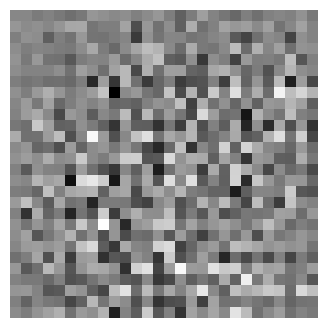

In [6]:
gen_model = generator_model()

noise = tf.random.normal([1, 100])
generated_image = gen_model(noise, training = False)

plt.figure(figsize = (4,4))
plt.axis(False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Defining Discriminator Model 

In [7]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides = (2,2), padding = 'same', input_shape = [28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5,5), strides = (2,2), padding = 'same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Testing Disciminator Model

In [8]:
dis_model = discriminator_model()
print(dis_model(generated_image))

tf.Tensor([[-0.00276198]], shape=(1, 1), dtype=float32)


Defining and Loss and Optimizers

In [9]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits = False)

In [10]:
#Defining Discriminator Loss
def dis_loss(real, fake):
    real_set_loss = loss(tf.ones_like(real), real)
    fake_set_loss = loss(tf.zeros_like(fake), fake)
    total_loss = real_set_loss + fake_set_loss
    return total_loss


In [11]:
#Defining Generator Loss
def gen_loss(fake):
    return loss(tf.ones_like(fake), fake)

In [12]:
#Defining Optimizers
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
dis_optimizer = tf.keras.optimizers.Adam(1e-4)

Training Loop

In [15]:
EPOCHS = 50
noise_dim = 100 
images = 16

seed = tf.random.normal([images, noise_dim])

In [16]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = gen_model(noise, training=True)

      real_output = dis_model(images, training=True)
      fake_output = dis_model(generated_images, training=True)

      generator_loss = gen_loss(fake_output)
      discriminator_loss = dis_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(generator_loss, gen_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(discriminator_loss, dis_model.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_of_generator, gen_model.trainable_variables))
    dis_optimizer.apply_gradients(zip(gradients_of_discriminator, dis_model.trainable_variables))

Generating and Saving Images

In [17]:
def vis(model, epoch, input):
    predictions = model(input, training = False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()